In [ ]:
#CE 595, Final Project. Heat Map of lexington based on walkability and total employment. 

In [ ]:
!conda config --prepend channels conda-forge
!conda create -n ox --strict-channel-priority osmnx



Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/anaconda3/envs/ox

  added / updated specs:
    - osmnx


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    affine-2.3.1               |     pyhd8ed1ab_0          17 KB  conda-forge
    attrs-21.4.0               |     pyhd8ed1ab_0          49 KB  conda-forge
    blosc-1.21.0               |       he49afe7_0         920 KB  conda-forge
    boost-cpp-1.74.0           |       hdbf7018_7        15.6 MB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    brotli-1.0.9               |       h5

In [239]:
#Everything that has to be imported and installed 
import pandas as pd
import geopandas as gpd
from pandas import DataFrame
import pandas as pd
from shapely.geometry import LineString, Point
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt
import folium 
from folium import plugins
from folium.plugins import HeatMap

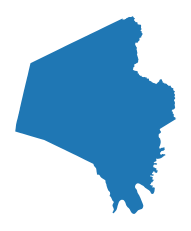

In [1]:
#Map of Lexington without streets and nodes. 
import osmnx as ox #Imports maps from OpenStreetMap
city = ox.geocode_to_gdf('Lexington, Kentucky')
ax = ox.project_gdf(city).plot()
_ = ax.axis('off')

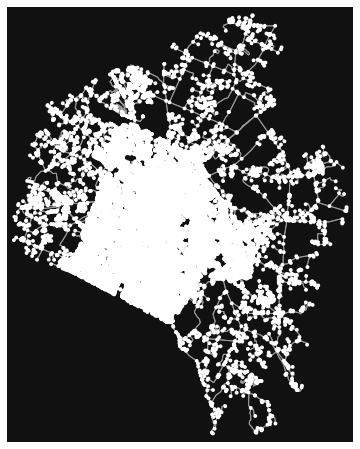

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
# Walking network of Lexington. 
W = ox.graph_from_place('Lexington, Kentucky', network_type='walk')
ox.plot_graph(W)

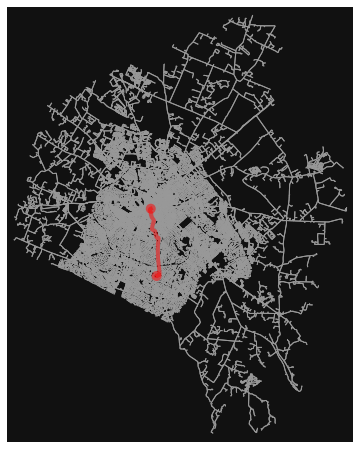

In [10]:
#Shortest path from my apartment to Gatton Student Center based on the walking map
origine = ox.distance.nearest_nodes(W, X=-84.497701, Y=37.982920)
destination = ox.distance.nearest_nodes(W, X=-84.503295, Y=38.040021)
route = ox.shortest_path(W, origine, destination, weight="length")
fig, ax = ox.plot_graph_route(W, route, node_size=0, )


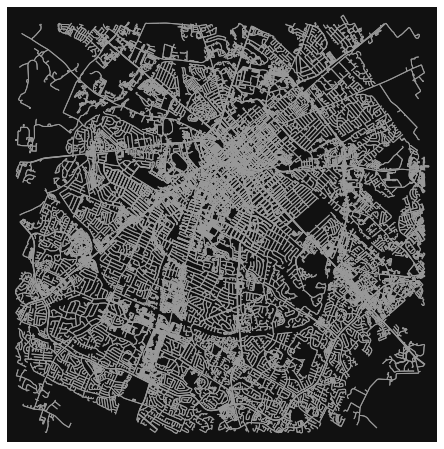

MultiDiGraph with 32442 nodes and 94548 edges


In [10]:
#This is the area that I wanted to use for the project, since the rest of Lexington is not very walkable. 
Kroger_Field = (38.02383082308054, -84.50249515971014) #coordinates of the base point 
five_miles = 7000  #meters-radius
K = ox.graph_from_point(Kroger_Field, dist=five_miles , network_type="walk")
fig, ax = ox.plot_graph(K, node_size=0)
print(K)

In [254]:
#Lat and log of all block groups for Lexington-Fayette County, I got this data from Census blocks 
#and opened it with QGIS. There were 4151 blocks. It is a lot of data to iterate through so I will need to sort it. 
df_latlog = pd.read_csv('Latlog.csv') # This is the csv file that I downloaded from QGIS
df_latlog

,geocode,Lag,Log
0,210670001011000,38.051584,-84.495588
1,210670001011001,38.051177,-84.495125
2,210670001011002,38.050399,-84.495173
3,210670001011003,38.050729,-84.496290
4,210670001011004,38.050204,-84.497616
...,...,...,...
4146,210670042102029,37.967434,-84.544668
4147,210670042102030,37.969358,-84.545058
4148,210670042102031,37.971638,-84.548492
4149,210670042102032,37.971524,-84.547863


In [241]:
# This is total employment. There are 1751 Total employments, that means that 2400 blocks have no jobs identified. 
#I will need to sort and match geocodes from blocks to employment. 
df_empl = pd.read_csv('tot_empl.csv')
df_empl

,geocode,Total emp
0,210670001011002,16
1,210670001011003,2
2,210670001011004,7
3,210670001011005,3
4,210670001011007,8
...,...,...
1746,210670042102009,5
1747,210670042102010,3
1748,210670042102018,4
1749,210670042102030,1


In [255]:
#It is a very large sample to work with, so I have decided to create a boundaries in order to get rid of some blocks
#that will not be inside of the boundary
# Here I ended up with 140 blocks within my boundary. Still a lot. I will use smaller sampler to practice. 
latitude = 38.03126673778558 # the middle point
longtitude = -84.49204387864383
square = 0.01 #the distance (radius)
df_latlog = df_latlog.loc[df_latlog['Lag']<(latitude+square)] # this just basicaly creates end point of the box
df_latlog = df_latlog.loc[df_latlog['Lag']>(latitude-square)]
df_latlog = df_latlog.loc[df_latlog['Log']<(longtitude+square)]
df_latlog = df_latlog.loc[df_latlog['Log']>(longtitude-square)]

df_latlog = df_latlog.reset_index()
df_latlog

,index,geocode,Lag,Log
0,95,210670001012017,38.041226,-84.492349
1,96,210670001012018,38.040390,-84.491465
2,97,210670001012019,38.041099,-84.492878
3,99,210670001012021,38.040981,-84.493784
4,105,210670001012027,38.040927,-84.496329
...,...,...,...,...
135,1204,210670024001001,38.023354,-84.499782
136,1229,210670024001026,38.022717,-84.498716
137,1230,210670024001027,38.022206,-84.497144
138,1231,210670024001028,38.022915,-84.495632


In [243]:
#The next step was to merge sorted 140 blockes and employment. I am going to do left merge, right column employment
# left column blocks. This gave me 140 blocs and their employment. 
# I replaced all NaN with 0, since we dont know what is employment there. 
df_merge = df_latlog.merge(df_empl, how='left', on='geocode')
df_merge['Total emp'] = df_merge['Total emp'].fillna(0)
df_merge

,index,geocode,Lag,Log,Total emp
0,95,210670001012017,38.041226,-84.492349,0.0
1,96,210670001012018,38.040390,-84.491465,333.0
2,97,210670001012019,38.041099,-84.492878,69.0
3,99,210670001012021,38.040981,-84.493784,131.0
4,105,210670001012027,38.040927,-84.496329,0.0
...,...,...,...,...,...
135,1204,210670024001001,38.023354,-84.499782,11228.0
136,1229,210670024001026,38.022717,-84.498716,12.0
137,1230,210670024001027,38.022206,-84.497144,5.0
138,1231,210670024001028,38.022915,-84.495632,0.0


In [273]:
# The first 5 rows will be my practice. If this works than everything works. 
# I am going to rename the colums. 
df_mergefive = df_merge.head()
df_mergefive
df_mergefive.rename(columns = {'Lag':'Lat_orig', 'Log':'Log_orig','Total emp':'Total_emp'}, inplace = True)
df_mergefive

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,index,geocode,Lat_orig,Log_orig,Total_emp
0,95,210670001012017,38.041226,-84.492349,0.0
1,96,210670001012018,38.040390,-84.491465,333.0
2,97,210670001012019,38.041099,-84.492878,69.0
3,99,210670001012021,38.040981,-84.493784,131.0
4,105,210670001012027,38.040927,-84.496329,0.0


In [263]:
df_new = df_latlog.merge(df_empl, how='left', on='geocode')
df_new['Total emp'] = df_merge['Total emp'].fillna(0)


In [330]:
#In this part of a code I was able to create a shortest path based on the dataframe with 5 rows and calculate time
#that takes to walk from Origine to Destination. It created a matrix, so it will iterate from 1 to 2, 1 to 3 and so on. 
# Then I converted length to miles and then to time by dividing by 3 mi/hr (average wlaking speed). Then I converted hr 
# to min 
#Then I needed to create a dictionary with geocode as a key and total employment as a value, to be able to insert it
# into a heatmap. 
for i in df_mergefive.iterrows(): 
    #print(i[1],'\n')
    for j in df_mergefive.iterrows(): #Lat and Log origin Iterates through each row and column for lat and log destintion, geocode, and total employment.
        #print(j[1],'\n')
        lat_o = i[1]['Lat_orig']
        log_o = i[1]['Log_orig']
        lat_d = j[1]['Lat_orig']
        log_d = j[1]['Log_orig']
        geo_code = j[1]['geocode']
        total_emp = j[1]['Total_emp']
    
        origin = ox.distance.nearest_nodes(K, log_o, lat_o)
        destin = ox.distance.nearest_nodes(K, log_d, lat_d)
        
        route = ox.shortest_path(K, origin, destin, weight="length")#Identifies a shortest path from O to D based on length
        length = nx.shortest_path_length(K, origin, destin, weight='length')# calculates the length in meters for every path
        mile = length * 0.000621371 #converts meters to miles
        time = mile/3.0 # time in hrs 
        time_min = time*60 # converting time to min 
        #my_dict1 = {} #creating a dictionary 
        #my_dict1 = [geo_code] # dictionary with integer keys
        names = ['Lag','log','Total emp']
        lst = []
        if time_min < 30: # this is my if statement, if walking time is more than 30 minutes itt will erase it
            lst.append([lat_d, log_d, total_emp])#This creates a list of latitude, longtitude and total jobs
            print(lst)
            
        
        #print(lat_o)
        #print(log_o)
        #print(lat_d)
    
        #print(log_d)


[[38.041226, -84.492349, 0.0]]
[[38.04039, -84.491465, 333.0]]
[[38.041099, -84.492878, 69.0]]
[[38.040981, -84.493784, 131.0]]
[[38.040927, -84.496329, 0.0]]
[[38.041226, -84.492349, 0.0]]
[[38.04039, -84.491465, 333.0]]
[[38.041099, -84.492878, 69.0]]
[[38.040981, -84.493784, 131.0]]
[[38.040927, -84.496329, 0.0]]
[[38.041226, -84.492349, 0.0]]
[[38.04039, -84.491465, 333.0]]
[[38.041099, -84.492878, 69.0]]
[[38.040981, -84.493784, 131.0]]
[[38.040927, -84.496329, 0.0]]
[[38.041226, -84.492349, 0.0]]
[[38.04039, -84.491465, 333.0]]
[[38.041099, -84.492878, 69.0]]
[[38.040981, -84.493784, 131.0]]
[[38.040927, -84.496329, 0.0]]
[[38.041226, -84.492349, 0.0]]
[[38.04039, -84.491465, 333.0]]
[[38.041099, -84.492878, 69.0]]
[[38.040981, -84.493784, 131.0]]
[[38.040927, -84.496329, 0.0]]


In [334]:
#I was not able to print the list from my for loop above, so I had to manualy create my dataframe out of the list to
#be able to insert it into a map. This data has been sorted based on the time that takes to walk from Origin to Destination
#All the paths that take more than 30 minutes were eleminated. Firts I created list of lists and then I named each column. 
#I know that it is not accurate method for larger numbers, but I could not figure out the other way. This issue will 
#will have to be solved before someone can use this code. 
data = [[38.041226, -84.492349, 0.0],#list of lists
[38.04039, -84.491465, 333.0],
[38.041099, -84.492878, 69.0],
[38.040981, -84.493784, 131.0],
[38.040927, -84.496329, 0.0],
[38.041226, -84.492349, 0.0],
[38.04039, -84.491465, 333.0],
[38.041099, -84.492878, 69.0],
[38.040981, -84.493784, 131.0],
[38.040927, -84.496329, 0.0],
[38.041226, -84.492349, 0.0],
[38.04039, -84.491465, 333.0],
[38.041099, -84.492878, 69.0],
[38.040981, -84.493784, 131.0],
[38.040927, -84.496329, 0.0],
[38.041226, -84.492349, 0.0],
[38.04039, -84.491465, 333.0],
[38.041099, -84.492878, 69.0],
[38.040981, -84.493784, 131.0],
[38.040927, -84.496329, 0.0],
[38.041226, -84.492349, 0.0],
[38.04039, -84.491465, 333.0],
[38.041099, -84.492878, 69.0],
[38.040981, -84.493784, 131.0],
[38.040927, -84.496329, 0.0]]
 
df1 = pd.DataFrame(data, columns = ['Lat', 'log','Total emp'])#Column names 
 
# print dataframe.
df1

,Lat,log,Total emp
0,38.041226,-84.492349,0.0
1,38.040390,-84.491465,333.0
2,38.041099,-84.492878,69.0
3,38.040981,-84.493784,131.0
4,38.040927,-84.496329,0.0
5,38.041226,-84.492349,0.0
6,38.040390,-84.491465,333.0
7,38.041099,-84.492878,69.0
8,38.040981,-84.493784,131.0
9,38.040927,-84.496329,0.0


In [339]:
#This Heatmap is based on data above. I got the lat,lo, total employment values from the dataframe that I have created.
#This Heatmap is only for 5 rows of data. The map does not have that much data in it. 
#The total employment is my weight for this system. 
#I had some issues thoughout this project and my main issue is itterating the data. 
#Red color is the most concentrated amount of jobs in the census block. The blue is the least. 

map_hooray = folium.Map(location=[38.046407, -84.497039],
            zoom_start = 12) 

df1['Lat'] = df1['Lat'].astype(float)
df1['log'] = df1['log'].astype(float)
df1['Total emp'] = df1['Total emp'].astype(float)
df1 = [[row['Lat'],row['log'],row['Total emp']] for index, row in df1.iterrows()]

HeatMap(df1).add_to(map_hooray)

map_hooray

In [332]:
#practice input for a heat map 
#1. I need to create a new dataframe with latitudes,longtitudes, weight(total employment)
# In this I have craeted a new dataframe from my previous dataframe that called df_latlog
#The new datframe called df_practice1 and it has 140 rows. 
df_latlog
df_practice = df_latlog[['Lag', 'Log']].copy()#renamed it to df_practice
df_merge# the dataframe above with lat, log, empl
df_practice1 = df_merge[['Lag', 'Log', 'Total emp']].copy() #created a new dataframe
print(df_practice1)

           Lag        Log  Total emp
0    38.041226 -84.492349        0.0
1    38.040390 -84.491465      333.0
2    38.041099 -84.492878       69.0
3    38.040981 -84.493784      131.0
4    38.040927 -84.496329        0.0
..         ...        ...        ...
135  38.023354 -84.499782    11228.0
136  38.022717 -84.498716       12.0
137  38.022206 -84.497144        5.0
138  38.022915 -84.495632        0.0
139  38.021570 -84.495789       32.0

[140 rows x 3 columns]


In [333]:
#HeatMap based on latitude, longtitude, and weight(Total employment).
#This map was created form the datafarme above df_practice1. There are 140 rows of data that has been inserted ito the map.
#The total employment is my weight for this system. 
#I created this heat map just based on the original data. For each census block there are jobs.
#So this heat map shows the amount of jobs in each block. 
#Red color is the most concentrated amount of jobs in the census block. The blue is the least. 

map_hooray1 = folium.Map(location=[38.046407, -84.497039],
            zoom_start = 12) 

df_practice1['Lag'] = df_practice1['Lag'].astype(float)
df_practice1['Log'] = df_practice1['Log'].astype(float)
df_practice1['Total emp'] = df_practice1['Total emp'].astype(float)
df_practice1 = [[row['Lag'],row['Log'],row['Total emp']] for index, row in df_practice1.iterrows()]

HeatMap(df_practice1).add_to(map_hooray1)

map_hooray1